**<hr>**

# <center>**PROMO TOOL**<br>prototype</center>

**<hr>**

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [1]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt

import sys

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm

import datetime
from dateutil.parser import *

In [2]:
from sklearn.pipeline import Pipeline
from transformers import dayName, dummy_days, DFStandardScaler, ZeroFillTransformer, DFFeatureUnion

In [3]:
import pickle

<hr>

# 0. **PREPROCESSING**

## 0.1. Auxiliary functions and lists

### 0.1.1. One Hot Encoding

The function _**ohe**_ takes dataframe and encodes column (actually index) _'date'_ into 7 columns _Day names_ with binary input.

In [5]:
def ohe(self):
    self['day_of_week'] = self.index.get_level_values('date').day_name()
    encoded_columns = pd.get_dummies(self['day_of_week'])
    self = self.join(encoded_columns)
    self = self.drop('day_of_week',axis=1)
    return self

### 0.1.2. Scaling

Before calling the following function we have to provide separate dataframes for train and test data _and_ state the name of the column we want to scale. The function differs test from training data and after the scaler is fitted to train data, it transformes both training and test data. <br> <br> **Later:** improve function so it could 
* take only one dataframe as an argument 
* separate data to test and train data
* store that information 
* finally scale columns like it's described

In [6]:
def scaling_columns_seperately(self_train,self_test,col):
    aux_df = self_train[col]
    std_scaler.fit(aux_df.values.reshape(-1,1))
    aux_df = std_scaler.transform(self_train[col].values.reshape(-1,1))
    self_train[col] = aux_df
    
    aux_df = self_test[col]
    aux_df = std_scaler.transform(self_test[col].values.reshape(-1,1))
    self_test[col] = aux_df

<br>Scaling through each column for an _item_ in a for loop. <br> **Note:** self_train and self_test dataframes have same columns.<br> <br>**Later:** improve the loop (make function) so it could iterate over items (28, ..., 57) --> data is taken from df  **X**.

### 0.1.3. Handling outliers

-- outliers could be removed or set to a specific value (capping, flooring)<br> -- firstly we will _**remove**_ them

In [16]:
def removing_outliers(self):
    upper_lim = self['amount'].quantile(.95)
    lower_lim = self['amount'].quantile(.05)
    self=self[(self['amount'] < upper_lim) & (self['amount'] > lower_lim)]
    return self

### 0.1.4. Separating training and test data

In [19]:
def X_train_test_separation(self):
    aux = self.loc[self.index.get_level_values('date') <= '2018-01-01']
    train = aux.drop('amount',axis=1)
    
    aux = self.loc[self.index.get_level_values('date') > '2018-01-01']
    test = aux.drop('amount',axis=1)
    
    return train, test

In [20]:
def y_train_test_separation(self):
    aux = self.loc[self.index.get_level_values('date') <= '2018-01-01']
    train = aux['amount']
    
    aux = self.loc[self.index.get_level_values('date') > '2018-01-01']
    test = aux['amount']
    
    return train, test

### 0.1.5. Function and list initialization

In [28]:
std_scaler = StandardScaler()
lm = linear_model.LinearRegression()

In [26]:
list_of_items = [38,39,40,41,57] 

In [27]:
rmse_train = []
rmse_test = []
r2 = []

In [3]:
categorical_features = ['day_of_week']
numerical_features = ['regular_price', 'discounted_price','number_of_stores']

## 0.2. Pipeline

Process:
   * separate dependent array _"amount"_ and _the rest of dataframe_ from the initial dataframe
   * separate data into train and test set
   * fit model on train set
   * transform both train and test set

In [4]:
pipeline = Pipeline([ ('features', DFFeatureUnion([       
                                                      ('categoricals', Pipeline([ ('dani',dayName()), ('dummyD', dummy_days())]))
                                                  ])), 
                      ('scaler', DFStandardScaler()) 
                   ])

TypeError: __init__() takes 1 positional argument but 2 were given

In [9]:
#saving pipeline to picikle

#pipeline_pickle_path = 'pipeline_pickle.pkl'
#pipeline_pickle = open (pipeline_pickle_path,'wb')
#pickle.dump(pipeline, pipeline_pickle)
#pipeline_pickle.close()

Loading pipeline from pipeline_pickle:

In [10]:
pipeline_pickle_path = 'pipeline_pickle.pkl'
pipeline_unpickle = open(pipeline_pickle_path, 'rb')
  
pipeline_from_pickle = pickle.load(pipeline_unpickle)

In [11]:
pipeline_from_pickle

Pipeline(memory=None,
         steps=[('features',
                 <transformers.DFFeatureUnion object at 0x000002AFD112CCC0>),
                ('scaler',
                 <transformers.DFStandardScaler object at 0x000002AFD112CEF0>)],
         verbose=False)

## 0.3. Data loading

In [12]:
X = pd.read_parquet("C:/Users/vvrhovec/Veronika/kodovi/radni_folder/parquet/X_prices_stores_amount.parquet")

C:\Users\vvrhovec\AppData\Local\Continuum\miniconda3\envs\okolina\lib\site-packages\pyarrow\pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
C:\Users\vvrhovec\AppData\Local\Continuum\miniconda3\envs\okolina\lib\site-packages\pyarrow\pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
C:\Users\vvrhovec\AppData\Local\Continuum\miniconda3\envs\okolina\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Napomena: srediti parquet fajlove za učitavanje svakog od artikla

In [13]:
X_38 = X.loc[38]
X_39 = X.loc[39]
X_40 = X.loc[40]
X_41 = X.loc[41]
X_57 = X.loc[57]

**<hr>**

# <center>**ITEMS**</center>

**<hr>**

# 1. ITEM 38

In [18]:
X_38.describe()

,regular_price,discounted_price,number_of_stores,amount
count,733.000000,733.000000,733.000000,733.000000
mean,0.099944,0.099944,420.538881,245.199181
std,0.000247,0.000247,21.571971,125.344983
min,0.098000,0.098000,368.000000,43.000000
25%,0.100000,0.100000,402.000000,143.000000
50%,0.100000,0.100000,420.000000,229.000000
75%,0.100000,0.100000,442.000000,339.000000
max,0.100000,0.100000,452.000000,552.000000


## 1.1. Data preprocessing

### 1.1.1. Removing outliers

In [17]:
X_38 = removing_outliers(X_38)

### 1.1.2. Separating data into training and test set

In [21]:
X_38_train, X_38_test =  X_train_test_separation(X_38)
y_38_train, y_38_test =  y_train_test_separation(X_38)

In [186]:
# X_38_train.to_parquet('X_38_train.parquet')
# X_38_test.to_parquet('X_38_test.parquet')

### 1.1.3. Pipeline

In [22]:
X_38_train = pipeline_from_pickle.fit_transform(X_38_train)
X_38_test = pipeline_from_pickle.transform(X_38_test)

In [23]:
print (X_38_train.shape, y_38_train.shape)
print (X_38_test.shape, y_38_test.shape)

(620, 10) (620,)
(113, 10) (113,)


## 1.2. Fitting and transforming

### 1.2.1. Training set

In [29]:
model_38 = lm.fit(X_38_train, y_38_train)

In [30]:
y_38_train_predicted = model_38.predict(X_38_train)

In [31]:
model_38.score(X_38_train,y_38_train)

0.20239898083401253

In [32]:
mae_38_train = mean_absolute_error(y_38_train, y_38_train_predicted)
mae_38_train

91.48894944468556

In [33]:
mse_38_train = mean_squared_error(y_38_train, y_38_train_predicted)
mse_38_train

12719.820428009101

In [34]:
rmse_38_train = np.sqrt(mean_squared_error(y_38_train, y_38_train_predicted))
rmse_train.append(rmse_38_train)
rmse_38_train

112.7821813408887

### 1.2.2. Test set

In [35]:
y_38_test_predicted = model_38.predict(X_38_test)

In [36]:
mae_38_test = mean_absolute_error(y_38_test, y_38_test_predicted)
mae_38_test

93.01551614873465

In [37]:
mse_38_test = mean_squared_error(y_38_test, y_38_test_predicted)
mse_38_test

12966.248050367642

Text(0, 0.5, 'predicted amount sold')

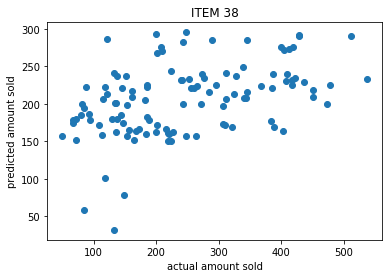

In [38]:
plt.scatter(y_38_test, y_38_test_predicted)
plt.title("ITEM 38")
plt.xlabel("actual amount sold")
plt.ylabel("predicted amount sold")

## 1.3. Error metrics

In [39]:
r2_score(y_38_test,y_38_test_predicted)

0.09172366773778362

In [40]:
r2.append(r2_score(y_38_test,y_38_test_predicted))

In [41]:
rmse_38_test = np.sqrt(mean_squared_error(y_38_test, y_38_test_predicted))
rmse_test.append(rmse_38_test)
rmse_38_test

113.86943422344577

# 2. ITEM 39

In [42]:
X_39.describe()

,regular_price,discounted_price,number_of_stores,amount
count,869.000000,869.000000,869.000000,869.000000
mean,0.099999,0.099999,458.894131,3445.628308
std,0.000034,0.000034,6.215435,1812.797700
min,0.099000,0.099000,423.000000,43.000000
25%,0.100000,0.100000,457.000000,2053.000000
50%,0.100000,0.100000,461.000000,3091.000000
75%,0.100000,0.100000,463.000000,4389.000000
max,0.100000,0.100000,467.000000,10120.000000


## 2.1. Data preprocessing

### 2.1.1. Removing outliers

In [43]:
X_39 = removing_outliers(X_39)

### 2.1.2. Separating data into training and test set

In [44]:
X_39_train, X_39_test =  X_train_test_separation(X_39)
y_39_train, y_39_test =  y_train_test_separation(X_39)

In [45]:
print (X_39_train.shape, y_39_train.shape)
print (X_39_test.shape, y_39_test.shape)

(643, 3) (643,)
(138, 3) (138,)


### 2.1.3. Pipeline

In [117]:
X_39_train = pipeline_from_pickle.fit_transform(X_39_train)
X_39_test = pipeline_from_pickle.transform(X_39_test)

In [118]:
print (X_39_train.shape, y_39_train.shape)
print (X_39_test.shape, y_39_test.shape)

(643, 10) (643,)
(138, 10) (138,)


## 2.2. Fitting and transforming

### 2.2.1. Training set

In [119]:
model_39 = lm.fit(X_39_train, y_39_train)

In [120]:
y_39_train_predicted = model_39.predict(X_39_train)

In [121]:
model_39.score(X_39_train, y_39_train)

0.249356618942476

In [122]:
mae_39_train = mean_absolute_error(y_39_train, y_39_train_predicted)
mae_39_train

962.5253621728317

In [123]:
mse_39_train = mean_squared_error(y_39_train, y_39_train_predicted)
mse_39_train

1460334.9457869066

In [124]:
rmse_39_train = np.sqrt(mean_squared_error(y_39_train, y_39_train_predicted))
rmse_train.append(rmse_39_train)
rmse_39_train

1208.443190963856

### 2.2.2. Test set

In [125]:
y_39_test_predicted = model_39.predict(X_39_test)

In [126]:
mae_39_test = mean_absolute_error(y_39_test, y_39_test_predicted)
mae_39_test

835.7810819147086

In [127]:
mse_39_test = mean_squared_error(y_39_test, y_39_test_predicted)
mse_39_test

1053298.9231401011

Text(0, 0.5, 'predicted amount sold')

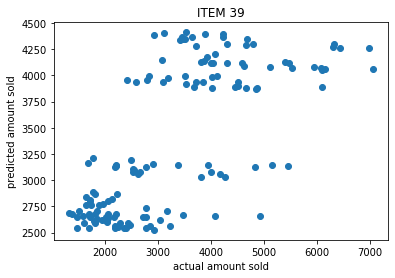

In [128]:
plt.scatter(y_39_test, y_39_test_predicted)
plt.title("ITEM 39")
plt.xlabel("actual amount sold")
plt.ylabel("predicted amount sold")

## 2.3. Error metrics

In [129]:
r2_score(y_39_test,y_39_test_predicted)

0.44506806718154923

In [130]:
r2.append(r2_score(y_39_test,y_39_test_predicted))

In [131]:
rmse_39_test = np.sqrt(mean_squared_error(y_39_test, y_39_test_predicted))
rmse_test.append(rmse_39_test)
rmse_39_test

1026.3035238856492

# 3. ITEM 40

In [60]:
X_40.describe()

,regular_price,discounted_price,number_of_stores,amount
count,869.000000,869.000000,869.000000,869.000000
mean,0.763195,0.684793,315.353280,156.615650
std,0.036849,0.120316,58.894878,115.959738
min,0.539000,0.249000,212.000000,4.000000
25%,0.769000,0.570000,268.000000,82.000000
50%,0.769000,0.769000,304.000000,128.000000
75%,0.770000,0.769000,333.000000,190.000000
max,0.771000,0.782000,450.000000,866.000000


## 3.1. Data preprocessing

### 3.1.1. Removing outliers

In [61]:
X_40 = removing_outliers(X_40)

### 3.1.2. Separating data into training and test set

In [62]:
X_40_train, X_40_test =  X_train_test_separation(X_40)
y_40_train, y_40_test =  y_train_test_separation(X_40)

### 3.1.3. Pipeline

In [132]:
X_40_train = pipeline_from_pickle.fit_transform(X_40_train)
X_40_test = pipeline_from_pickle.transform(X_40_test)

In [133]:
print (X_40_train.shape, y_40_train.shape)
print (X_40_test.shape, y_40_test.shape)

(644, 10) (644,)
(136, 10) (136,)


## 3.2. Fitting and transforming

### 3.2.1. Training set

In [134]:
model_40 = lm.fit(X_40_train, y_40_train)

In [135]:
y_40_train_predicted = model_40.predict(X_40_train)

In [136]:
model_40.score(X_40_train, y_40_train)

0.4225868525901731

In [137]:
mae_40_train = mean_absolute_error(y_40_train, y_40_train_predicted)
mae_40_train

41.425561232220375

In [138]:
mse_40_train = mean_squared_error(y_40_train, y_40_train_predicted)
mse_40_train

3101.960979543542

In [139]:
rmse_40_train = np.sqrt(mean_squared_error(y_40_train, y_40_train_predicted))
rmse_train.append(rmse_40_train)
rmse_40_train

55.69525096041441

### 3.2.2. Test set

In [140]:
y_40_test_predicted = model_40.predict(X_40_test)

In [141]:
mae_40_test = mean_absolute_error(y_40_test, y_40_test_predicted)
mae_40_test

40.866519280297794

In [142]:
mse_40_test = mean_squared_error(y_40_test, y_40_test_predicted)
mse_40_test

2943.234272835755

Text(0, 0.5, 'predicted amount sold')

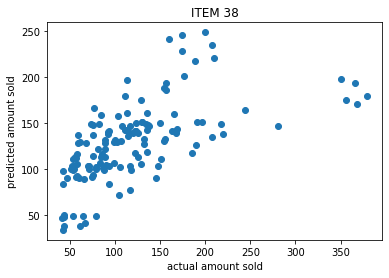

In [143]:
plt.scatter(y_40_test, y_40_test_predicted)
plt.title("ITEM 38")
plt.xlabel("actual amount sold")
plt.ylabel("predicted amount sold")

## 3.3. Error metrics

In [144]:
r2_score(y_40_test,y_40_test_predicted)

0.3594811397084795

In [145]:
r2.append(r2_score(y_40_test,y_40_test_predicted))

In [146]:
rmse_40_test = np.sqrt(mean_squared_error(y_40_test, y_40_test_predicted))
rmse_test.append(rmse_40_test)
rmse_40_test

54.2515831366768

# 4. ITEM 41

In [147]:
X_41.describe()

,regular_price,discounted_price,number_of_stores,amount
count,773.000000,773.000000,773.000000,773.000000
mean,1.631208,1.619985,124.498060,28.875809
std,0.000591,0.062288,29.772698,12.273654
min,1.630000,1.078000,92.000000,8.000000
25%,1.631000,1.631000,99.000000,19.000000
50%,1.631000,1.631000,115.000000,27.000000
75%,1.632000,1.632000,152.000000,37.000000
max,1.632000,1.705000,185.000000,58.000000


## 4.1. Data preprocessing

### 4.1.1. Removing outliers

In [78]:
X_41 = removing_outliers(X_41)

### 4.1.2. Separating data into training and test set

In [79]:
X_41_train, X_41_test =  X_train_test_separation(X_41)
y_41_train, y_41_test =  y_train_test_separation(X_41)

### 4.1.3. Pipeline

In [148]:
X_41_train = pipeline_from_pickle.fit_transform(X_41_train)
X_41_test = pipeline_from_pickle.transform(X_41_test)

In [149]:
print (X_41_train.shape, y_41_train.shape)
print (X_41_test.shape, y_41_test.shape)

(645, 10) (645,)
(128, 10) (128,)


## 4.2. Fitting and transforming

### 4.2.1. Training set

In [150]:
model_41 = lm.fit(X_41_train, y_41_train)

In [151]:
y_41_train_predicted = model_41.predict(X_41_train)

In [152]:
model_41.score(X_41_train, y_41_train)

0.4795487790452177

In [153]:
mae_41_train = mean_absolute_error(y_41_train, y_41_train_predicted)
mae_41_train

6.924228821690725

In [154]:
mse_41_train = mean_squared_error(y_41_train, y_41_train_predicted)
mse_41_train

77.30401190921812

In [155]:
rmse_41_train = np.sqrt(mean_squared_error(y_41_train, y_41_train_predicted))
rmse_train.append(rmse_41_train)
rmse_41_train

8.79227000888952

### 4.2.1. Training set

In [156]:
y_41_test_predicted = model_41.predict(X_41_test)

In [157]:
mae_41_test = mean_absolute_error(y_41_test, y_41_test_predicted)
mae_41_test

8.959824408152604

In [158]:
mse_41_test = mean_squared_error(y_41_test, y_41_test_predicted)
mse_41_test

113.12938355259311

Text(0, 0.5, 'predicted amount sold')

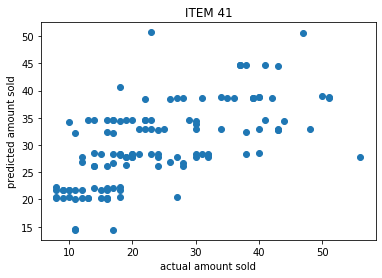

In [159]:
plt.scatter(y_41_test, y_41_test_predicted)
plt.title("ITEM 41")
plt.xlabel("actual amount sold")
plt.ylabel("predicted amount sold")

## 4.3. Error metrics

In [160]:
r2_score(y_41_test,y_41_test_predicted)

0.15859610141011515

In [161]:
r2.append(r2_score(y_41_test,y_41_test_predicted))

In [162]:
rmse_41_test = np.sqrt(mean_squared_error(y_41_test, y_41_test_predicted))
rmse_test.append(rmse_41_test)
rmse_41_test

10.636229762119335

# 5. ITEM 57

In [95]:
X_57.describe()

,regular_price,discounted_price,number_of_stores,amount
count,801.000000,801.000000,801.000000,801.000000
mean,0.080722,0.080722,87.906367,60.675406
std,0.002036,0.002036,8.902105,44.194819
min,0.079000,0.079000,70.000000,1.000000
25%,0.080000,0.080000,81.000000,32.000000
50%,0.080000,0.080000,88.000000,52.000000
75%,0.081000,0.081000,94.000000,75.000000
max,0.122000,0.122000,107.000000,372.000000


## 5.1. Data preprocessing

### 5.1.1. Removing outliers

In [96]:
X_57 = removing_outliers(X_57)

### 5.1.2. Separating data into training and test set

In [97]:
X_57_train, X_57_test =  X_train_test_separation(X_57)
y_57_train, y_57_test =  y_train_test_separation(X_57)

### 5.1.3. Pipeline

In [163]:
X_57_train = pipeline_from_pickle.fit_transform(X_57_train)
X_57_test = pipeline_from_pickle.transform(X_57_test)

In [164]:
print (X_57_train.shape, y_57_train.shape)
print (X_57_test.shape, y_57_test.shape)

(617, 10) (617,)
(97, 10) (97,)


## 5.2. Fitting and transforming

### 5.2.1. Training set

In [165]:
model_57 = lm.fit(X_57_train, y_57_train)

In [166]:
y_57_train_predicted = model_57.predict(X_57_train)

In [167]:
model_57.score(X_57_train, y_57_train)

0.34496441419862917

In [168]:
mae_57_train = mean_absolute_error(y_57_train, y_57_train_predicted)
mae_57_train

17.193308379927526

In [169]:
mse_57_train = mean_squared_error(y_57_train, y_57_train_predicted)
mse_57_train

486.23376758228125

In [170]:
rmse_57_train = np.sqrt(mean_squared_error(y_57_train, y_57_train_predicted))
rmse_train.append(rmse_57_train)
rmse_57_train

22.050709004072438

### 5.2.2. Training set

In [171]:
y_57_test_predicted = model_57.predict(X_57_test)

In [172]:
mae_57_test = mean_absolute_error(y_57_test, y_57_test_predicted)
mae_57_test

19.684160945801878

In [173]:
mse_57_test = mean_squared_error(y_57_test, y_57_test_predicted)
mse_57_test

589.4800721357734

Text(0, 0.5, 'predicted amount sold')

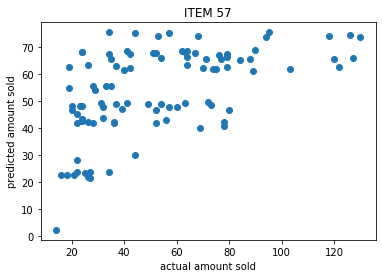

In [174]:
plt.scatter(y_57_test, y_57_test_predicted)
plt.title("ITEM 57")
plt.xlabel("actual amount sold")
plt.ylabel("predicted amount sold")

## 5.3. Error metrics

In [175]:
r2_score(y_57_test,y_57_test_predicted)

0.29449318781533085

In [176]:
r2.append(r2_score(y_57_test,y_57_test_predicted))

In [177]:
rmse_57_test = np.sqrt(mean_squared_error(y_57_test, y_57_test_predicted))
rmse_test.append(rmse_57_test)
rmse_57_test

24.27921069836854

# 6. CONCLUSION

In [178]:
rmse_train

[112.7821813408887,
 1386.470035345312,
 64.70490049363099,
 11.745645765913721,
 23.78118609440148,
 1208.443190963856,
 55.69525096041441,
 8.79227000888952,
 22.050709004072438]

In [179]:
rmse_test

[113.86943422344577,
 1275.1499941919494,
 61.13769461211335,
 12.192825022586801,
 25.401432230613587,
 1026.3035238856492,
 54.2515831366768,
 10.636229762119335,
 24.27921069836854]

In [180]:
r2

[0.09172366773778362,
 0.14333579082332015,
 0.1865605953053039,
 -0.10570120279033168,
 0.22776675803741764,
 0.44506806718154923,
 0.3594811397084795,
 0.15859610141011515,
 0.29449318781533085]

In [181]:
for i in range(0,len(list_of_items)):
    print (list_of_items[i],": ", rmse_train[i])

38 :  112.7821813408887
39 :  1386.470035345312
40 :  64.70490049363099
41 :  11.745645765913721
57 :  23.78118609440148
